In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# read data
from IPython.display import display

try: 
    train = pd.read_csv("../data/train.csv")
    test = pd.read_csv("../data/test.csv")
    print "Import Data Succesful"
except:
    print "Unexpected error:", sys.exc_info()[0]

Import Data Succesful


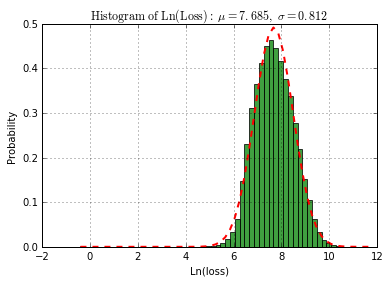

In [3]:
features = [x for x in train.columns if x not in ['id','loss']]
#print(features)

cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]
# print(cat_features)
# print(num_features)

from scipy.stats import norm, lognorm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

train['log_loss'] = np.log(train['loss'])

# fit the normal distribution on ln(loss)
(mu, sigma) = norm.fit(train['log_loss'])

# the histogram of the ln(loss)
n, bins, patches = plt.hist(train['log_loss'], 60, normed=1, facecolor='green', alpha=0.75)

# add the fitted line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Ln(loss)')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Ln(Loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

In [4]:
#combine test and train data for labelencoder purpose
train['is_test'] = 0
test['is_test'] = 1
full_data = train.append(test)

print full_data.shape
print "complete combine data"

(313864, 134)
complete combine data


In [5]:
variable_drop_list = ['log_loss', 'loss','id','is_test']

from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
d = defaultdict(LabelEncoder)


# Initialize new output DataFrame
full_col_list = [x for x in full_data.columns]
col_list = [x for x in full_data.select_dtypes(include=['object']).columns if x not in variable_drop_list]
if len(col_list) != 0:
    # Encoding the variable
    full_data_final = full_data[col_list].apply(lambda x: d[x.name].fit_transform(x))
    for column in full_data.columns:
        if column not in col_list:
            full_data_final[column] = full_data[column]
    full_data_final = pd.DataFrame(data = full_data_final, columns = full_col_list)

#     # Inverse the encoded
#     train_reversed = train.apply(lambda x: d[x.name].inverse_transform(x) if x.name not in variable_drop_list)
   
print full_data_final.shape

print "Processed feature columns ({} total features)".format(len(full_data_final.columns))

(313864, 134)
Processed feature columns (134 total features)


In [8]:
# compute skew and do Box-Cox transformation
from scipy.stats import skew, boxcox
skewed_feats = train[num_features].apply(lambda x: skew(x.dropna()))
print("\nSkew in numeric features:")
print(skewed_feats)

# transform features with skew > 0.25 (this can be varied to find optimal value)
skewed_feats = skewed_feats[skewed_feats > 0.25]
skewed_feats = skewed_feats.index
for feats in skewed_feats:
    full_data_final[feats] = full_data_final[feats] + 1
    full_data_final[feats], lam = boxcox(full_data_final[feats])
features = train.columns
cats = [feat for feat in features if 'cat' in feat]

print "box-cox transform finished"


Skew in numeric features:
cont1     0.516420
cont2    -0.310939
cont3    -0.010002
cont4     0.416093
cont5     0.681617
cont6     0.461211
cont7     0.826046
cont8     0.676629
cont9     1.072420
cont10    0.354998
cont11    0.280819
cont12    0.291990
cont13    0.380739
cont14    0.248672
dtype: float64


In [9]:
#split test predict/test/train data and random shuffle
# RANDOM SHUFFLE DATA
full_data_final = full_data_final.iloc[np.random.permutation(len(full_data_final))]
full_data_final.index = range(len(full_data_final))

train_data = full_data_final[(full_data_final.is_test == 0)]
test_data = full_data_final[(full_data_final.is_test == 1)]

target = train_data['log_loss']
test_id = test_data['id']

#drop text and unuseful field
train_data.drop(variable_drop_list,axis=1, inplace=True)
test_data.drop(variable_drop_list,axis=1, inplace=True)

print "data pre-process finished"

data pre-process finished


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
display(train_data.head())

,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,...,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9
0,0,0,8,0,0,0,7,3,6,8,...,0.398481,0.300582,0.555782,0.150744,0.377111,0.228916,0.432158,0.240724,0.336701,0.299110
3,0,0,11,2,0,0,6,6,6,9,...,0.351773,0.602254,0.681761,0.673861,0.302276,0.174663,0.374500,0.274661,0.299908,0.248105
5,0,1,9,12,0,0,6,7,7,6,...,0.235490,0.360592,0.358319,0.745801,0.172710,0.174663,0.284657,0.278212,0.187892,0.253132
6,0,0,7,0,0,3,5,4,7,5,...,0.213380,0.721994,0.299102,0.246911,0.451610,0.174663,0.250533,0.205976,0.233157,0.224386
7,0,0,8,0,0,2,4,5,7,5,...,0.239887,0.216856,0.785784,0.549770,0.311978,0.234228,0.261559,0.222528,0.284866,0.237881


In [12]:
#using gradient boost regressor
#note regressor is using linear regression, so normality transform is necessary in data pre-processing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score

# USE MSE AS SCORE FUNCTION
mse_score = make_scorer(mean_squared_error, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'mse_insample', 'mse_outsample'])

kf = cross_validation.KFold(len(train_data), n_folds=5)


target_train = pd.DataFrame(target,columns = ['log_loss'])
target_train.index = range(len(target_train))

for max_depth in range(2,11,1):
    print "running on max_depth:=", max_depth
    avg_mes_insample = 0.0  
    avg_mes_outsample = 0.0  
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = train_data.iloc[train], train_data.iloc[test], target_train.iloc[train], target_train.iloc[test]    
        clf = GradientBoostingRegressor(max_depth=max_depth, 
                                        n_estimators=500,
                                        random_state = 42
                                       )
        clf.fit(X_train, np.ravel(Y_train))
        avg_mes_insample += np.sqrt(mean_squared_error(np.ravel(Y_train),clf.predict(X_train)))
        avg_mes_outsample += np.sqrt(mean_squared_error(np.ravel(Y_test),clf.predict(X_test)))
    print "In Sample MSE is :=", avg_mes_insample/5.0, "; Out Sample MSE is :=", avg_mes_outsample/5.0                            
    score_record = score_record.append(pd.DataFrame([[max_depth, avg_mes_insample/5.0, avg_mes_outsample/5.0]],
                                                    columns=['max_depth', 'mse_insample', 'mse_outsample']))
    
score_record[score_record.mse_outsample == score_record.mse_outsample.max()]
best_estimation = score_record[score_record.mse_outsample == score_record.mse_outsample.max()]

print "best Out Of BAG max_depth based on mse_outsample:"
print best_estimation.max_depth[0]
print "best Out Of BAG MSE:"
print score_record.sort_values(by = ['mse_outsample'],ascending=False).head(1)

print('finished modeling')

running on max_depth:= 5
In Sample MSE is := 0.508995832166 ; Out Sample MSE is := 0.538973206335
running on max_depth:= 6
In Sample MSE is := 0.487089807457 ; Out Sample MSE is := 0.538619166426
running on max_depth:= 7
In Sample MSE is := 0.458210736308 ; Out Sample MSE is := 0.539863602468
best Out Of BAG max_depth based on mse_outsample:
7.0
best Out Of BAG MSE:
   max_depth  mse_insample  mse_outsample
0        6.0       0.48709       0.538619
finished modeling


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer,mean_squared_error

clf_gbr = GradientBoostingRegressor(max_depth=6, n_estimators=10000, random_state=24)
clf_gbr.fit(train_data,np.ravel(target_train))
print "GBR MSE on data",mean_squared_error(target_train,clf_gbr.predict(train_data))              

In [18]:
# Prediction
predicted_value = pd.DataFrame(np.exp(clf_gbr.predict(test_data)), columns=['loss'])
test_id.index = range(len(test_id))
predicted_value_pd = pd.concat([test_id, predicted_value], axis=1)

print 'finish predication'                                

finish predication


In [20]:
#  OUTPUT TO CSV
predicted_value_sorted = predicted_value_pd.sort_values(by = ['id'],ascending=False)
predicted_value_sorted.to_csv('../output/predications.csv', index=False)
print 'output finish'

output finish
